In [1]:
import numpy as np
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
NSAMPLE = 5
NSAMPLETEST = 10000
prior_scale = 0.01
seed = 1
lr = 0.005
num_epochs = 1000
verbose = True
Ts = [0.1, 1.0, 10.0, 100.0, 1000.0]

MODEL_MISSSPECIFICATION = True
if MODEL_MISSSPECIFICATION:
    VAR = 0.01
else:
    VAR = 1.0
    
LEARNING_METHOD = 2
if LEARNING_METHOD == 1:
    hmaxFlag = False
else:
    hmaxFlag = True

In [3]:
def sampleData(samples, variance):
    x = np.linspace(-10.5, 10.5, samples).reshape(-1, 1)
    r = 1 + np.float32(np.random.normal(size=(samples, 1), scale=variance))
    y = np.float32(x * 1.0 + r * 1.0)
    return (x, y)


def model(NSAMPLE):
    W = ed.MultivariateNormalTriL(
        tf.zeros([1, 2]), tf.zeros([2, 2]) + tf.eye(2) * prior_scale, name="W"
    )

    x = ed.Normal(loc=tf.zeros([NSAMPLE, 1]), scale=1.0, name="x")

    out = tf.matmul(x, W)[:, 0] + tf.matmul(tf.ones(x.shape), W)[:, 1]
    out = tf.expand_dims(out, 1)
    y = ed.Normal(loc=out, scale=1.0, name="y")

    return W, x, y


def qmodel():
    qmu0 = tf.Variable(tf.random_normal([1, 2], 0.0, 0.05, dtype=tf.float32))
    qR = tf.Variable(tf.random_normal([2, 2], 0.0, stddev=0.05, dtype=tf.float32))

    qW = ed.MultivariateNormalTriL(qmu0, qR, name="W")
    qW_ = ed.MultivariateNormalTriL(qmu0, qR, name="W")

    return qW, qW_

In [4]:
np.random.seed(seed)
tf.set_random_seed(seed)

(x_train, y_train) = sampleData(NSAMPLE, VAR)
(x_test, y_test) = sampleData(NSAMPLETEST, VAR)

# plt.scatter(x_train, y_train, marker='+', label='Training data')
# plt.ylim(-20,20)
# plt.xticks(np.arange(-10.5, 10.5, 4))
# plt.legend()
# plt.show()

# plt.scatter(x_test, y_test, marker='+', label='Test data')
# plt.ylim(-20,20)
# plt.xticks(np.arange(-10.5, 10.5, 4))
# plt.legend()
# plt.show()

/home/nsq277/miniconda3/envs/cpe_pacbayes_vi_tf/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  if __name__ == '__main__':


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
.
0 epochs	80.98789..........
100 epochs	28.222927..........
200 epochs	29.967424..........
300 epochs	32.41238..........
400 epochs	29.201494..........
500 epochs	30.473013..........
600 epochs	32.62922..........
700 epochs	29.663055..........
800 epochs	37.38185..........
900 epochs	29.760614..........
1000 epochs	29.16608

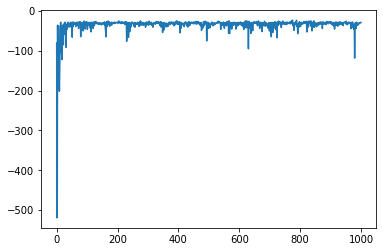

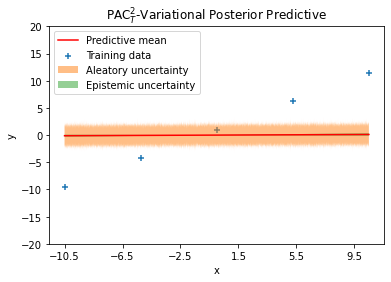


 lamb: 0.1, nll: 191718.15625
.
0 epochs	30.796833..........
100 epochs	48.335594..........
200 epochs	108.66521..........
300 epochs	46.656986..........
400 epochs	64.16401..........
500 epochs	52.438297..........
600 epochs	45.996525..........
700 epochs	42.10802..........
800 epochs	37.66755..........
900 epochs	47.504272..........
1000 epochs	26.358175

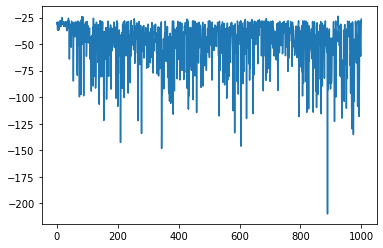

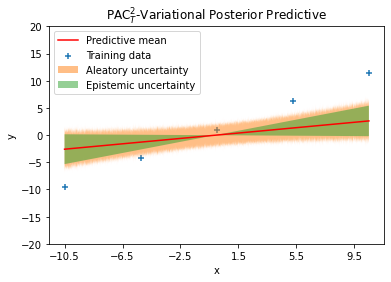


 lamb: 1.0, nll: 63959.27734375
.
0 epochs	29.306858..........
100 epochs	23.455223..........
200 epochs	29.519825..........
300 epochs	28.303337..........
400 epochs	48.782677..........
500 epochs	34.713036..........
600 epochs	30.040756..........
700 epochs	35.704765..........
800 epochs	43.663345..........
900 epochs	30.805845..........
1000 epochs	27.774637

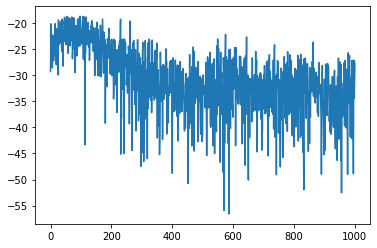

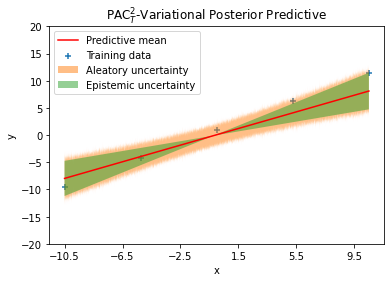


 lamb: 10.0, nll: 17771.76171875
.
0 epochs	29.077078..........
100 epochs	6.7738028..........
200 epochs	20.076286..........
300 epochs	9.929943..........
400 epochs	10.070639..........
500 epochs	10.459714..........
600 epochs	6.3039494..........
700 epochs	9.072086..........
800 epochs	10.438824..........
900 epochs	9.107515..........
1000 epochs	8.947813

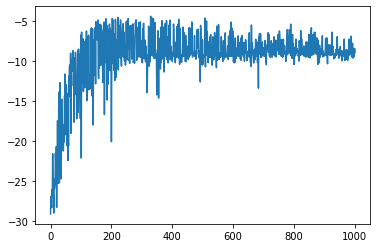

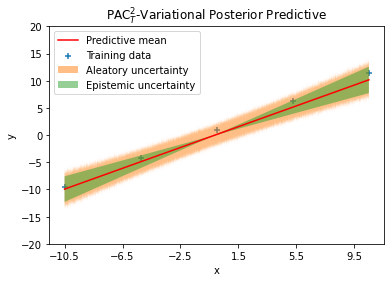


 lamb: 100.0, nll: 14191.888671875
.
0 epochs	24.91395..........
100 epochs	17.452864..........
200 epochs	10.423239..........
300 epochs	0.21752727..........
400 epochs	3.6293874..........
500 epochs	4.293257..........
600 epochs	3.613513..........
700 epochs	3.0296738..........
800 epochs	2.9157782..........
900 epochs	3.2554111..........
1000 epochs	2.371593

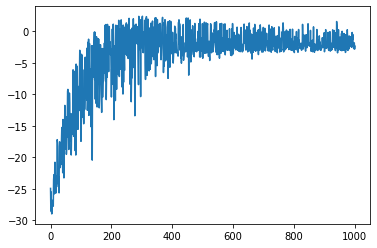

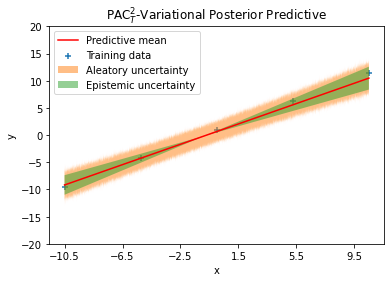


 lamb: 1000.0, nll: 11652.85546875


In [5]:
nlls = []
for lamb in Ts:
    ## Control the presence of model miss-specficication as shown in Figures 2 and 3.

    # Set seeds for reproducibility

    W, x, y = model(NSAMPLE)

    qW, qW_ = qmodel()
    qW2, qW2_ = qmodel()
    qW3, qW3_ = qmodel()

    with ed.interception(ed.make_value_setter(W=qW, x=x_train, y=y_train)):
        pW, px, py = model(NSAMPLE)
    with ed.interception(ed.make_value_setter(W=qW_, x=x_train, y=y_train)):
        pW_, px_, py_ = model(NSAMPLE)

    with ed.interception(ed.make_value_setter(W=qW2, x=x_train, y=y_train)):
        pW2, px2, py2 = model(NSAMPLE)
    with ed.interception(ed.make_value_setter(W=qW2_, x=x_train, y=y_train)):
        pW2_, px2_, py2_ = model(NSAMPLE)

    with ed.interception(ed.make_value_setter(W=qW3, x=x_train, y=y_train)):
        pW3, px3, py3 = model(NSAMPLE)
    with ed.interception(ed.make_value_setter(W=qW3_, x=x_train, y=y_train)):
        pW3_, px3_, py3_ = model(NSAMPLE)

    logmax = tf.stop_gradient(
        tf.math.maximum(
            py.distribution.log_prob(y_train), py_.distribution.log_prob(y_train)
        )
        + 0.1
    )
    logmean = tf.math.reduce_logsumexp(
        tf.concat(
            [py.distribution.log_prob(y_train), py_.distribution.log_prob(y_train)], 1
        ),
        axis=1,
    ) - tf.log(2.0)
    inc = tf.expand_dims(logmean, 1) - logmax

    if hmaxFlag:
        hmax = 2 * tf.stop_gradient(
            inc / tf.math.pow(1 - tf.math.exp(inc), 2)
            + tf.math.pow(tf.math.exp(inc) * (1 - tf.math.exp(inc)), -1)
        )
    else:
        hmax = 1.0

    var = 0.5 * (
        tf.reduce_sum(tf.exp(2 * py.distribution.log_prob(y_train) - 2 * logmax) * hmax)
        - tf.reduce_sum(
            tf.exp(
                py.distribution.log_prob(y_train)
                + py_.distribution.log_prob(y_train)
                - 2 * logmax
            )
            * hmax
        )
    )

    datalikelihood = tf.reduce_mean(py.distribution.log_prob(py.value))
    datalikelihood += tf.reduce_mean(py2.distribution.log_prob(py2.value))
    datalikelihood += tf.reduce_mean(py3.distribution.log_prob(py3.value))
    datalikelihood /= 3

    KL = tf.reduce_sum(qW.distribution.log_prob(qW.value)) - tf.reduce_sum(
        pW.distribution.log_prob(pW.value)
    )
    KL += tf.reduce_sum(qW2.distribution.log_prob(qW2.value)) - tf.reduce_sum(
        pW2.distribution.log_prob(pW2.value)
    )
    KL += tf.reduce_sum(qW3.distribution.log_prob(qW3.value)) - tf.reduce_sum(
        pW3.distribution.log_prob(pW3.value)
    )
    KL /= 3

    pacelbo = datalikelihood + var - KL / (lamb * NSAMPLE)

    sess = tf.Session()
    optimizer = tf.train.AdamOptimizer(lr)
    t = []
    train = optimizer.minimize(-pacelbo)
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(num_epochs + 1):
        t.append(sess.run(pacelbo))
        sess.run(train)
        if verbose:
            if i % 10 == 0:
                print(".", end="", flush=True)
            if i % 100 == 0:
                str_elbo = str(-t[-1])
                print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)

    plt.plot(t)
    plt.savefig(f"loss_pacelbo_{lamb}.png")
    plt.show()

    with ed.interception(ed.make_value_setter(W=qW, x=x_test)):
        pW, px, py = model(NSAMPLETEST)

    # plt.figure(figsize=(8, 8))
    y_pred_list = []
    y_pred_noise = []
    
    for i in range(20):
        [mean, noise] = sess.run([py.distribution.mean(), py])
        y_pred_list.append(mean)
        y_pred_noise.append(noise)

    y_preds = np.concatenate(y_pred_list, axis=1)
    y_preds_noise = np.concatenate(y_pred_noise, axis=1)

    y_mean = np.mean(y_preds, axis=1)
    y_sigma = np.std(y_preds, axis=1)

    y_sigma_noise = np.std(y_preds_noise, axis=1)

    plt.plot(x_test, y_mean, 'r-', label='Predictive mean');
    plt.scatter(x_train, y_train, marker='+', label='Training data')
    plt.fill_between(x_test.ravel(),
                     y_mean + 2 * y_sigma_noise,
                     y_mean - 2 * y_sigma_noise,
                     alpha=0.5, label='Aleatory uncertainty')

    plt.fill_between(x_test.ravel(),
                     y_mean + 2 * y_sigma,
                     y_mean - 2 * y_sigma,
                     alpha=0.5, label='Epistemic uncertainty')


    plt.ylabel('y')
    plt.xlabel('x')

    plt.ylim(-20,20)
    plt.xticks(np.arange(-10.5, 10.5, 4))
    plt.legend();

    if hmaxFlag:
        plt.title(r'PAC$^2_T$-Variational Posterior Predictive')
    else:
        plt.title(r'PAC$^2$-Variational Posterior Predictive')
    plt.savefig(f"fit_pacelbo_{lamb}.png")
    plt.show()

    y_pred_list = []
    for i in range(20):
        y_pred_list.append(sess.run(py.distribution.log_prob(y_test)))

    y_preds = tf.concat(y_pred_list, axis=1)

    score = -(tf.reduce_sum(tf.math.reduce_logsumexp(y_preds, axis=1) - tf.log(20.0)))

    score = sess.run(score)
    nlls.append(score)
    print(f"\n lamb: {lamb}, nll: {score}")


In [6]:
print(nlls)

[191718.16, 63959.277, 17771.762, 14191.889, 11652.855]


In [7]:
nlls_elbo = [194297.86, 186257.97, 127144.13, 26622.613, 11632.672]

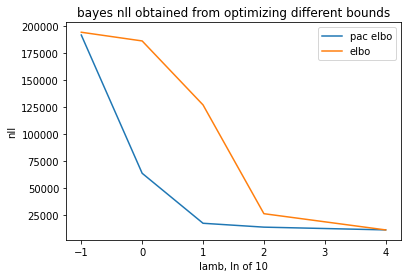

In [9]:
plt.figure()
plt.title("bayes nll obtained from optimizing different bounds")
plt.plot([-1, 0, 1, 2, 4], nlls, label="pac elbo")
plt.plot([-1, 0, 1, 2, 4], nlls_elbo, label="elbo")
plt.ylabel("nll")
plt.xlabel("lamb, ln of 10")
plt.legend()
plt.savefig("result.png")
plt.show()